In [1]:
import tensorflow as tf

In [2]:
from data.dataloader import tf_data_generator
from models.losses import tf_loss_function_mat

In [3]:
from models.gru_denoiser import BiGRUSpectralDenoiserTensorFlow

In [4]:
from training.trainer import Trainer_tf

In [5]:
from estimator.QIS import tf_QIS_batched

In [6]:
import numpy as np
import matplotlib.pyplot as plt

## NN

In [7]:
def mse(A, B):
    A = tf.cast(A, tf.float32)
    B = tf.cast(B, tf.float32)
    return tf.reduce_mean(tf.square(A - B))

In [8]:
N_min = 70
N_max = 250
T_min = 30
T_max = 70
batch_size=100

### Training loop — Generated Data

In [9]:
model_generated_data = BiGRUSpectralDenoiserTensorFlow(hidden_size=96) # hidden_size to be tunned 
# lr, weight_decay, batch_size, epochs, hidden_size to be tunned

In [10]:
trainer = Trainer_tf(
    model=model_generated_data, is_train_on_real_data = False, loss_function=tf_loss_function_mat, data_generator=tf_data_generator, lr = 1e-4, weight_decay=1e-5,
    batch_size=batch_size, epochs=30, N_min=N_min, N_max=N_max, T_min=T_min, T_max=T_max, log_interval=10, accumulate_steps=2, dataset=None, missing_constant = 2,
)
# need to epochs to be big when there is lot of choise for N and T 
# need for big batch_size when df is big
losses = trainer.train()

Starting training for 30 epochs…
Epoch 10/30 — loss: 0.01311897
Epoch 20/30 — loss: 0.01379772
Epoch 30/30 — loss: 0.01158377
Training complete.


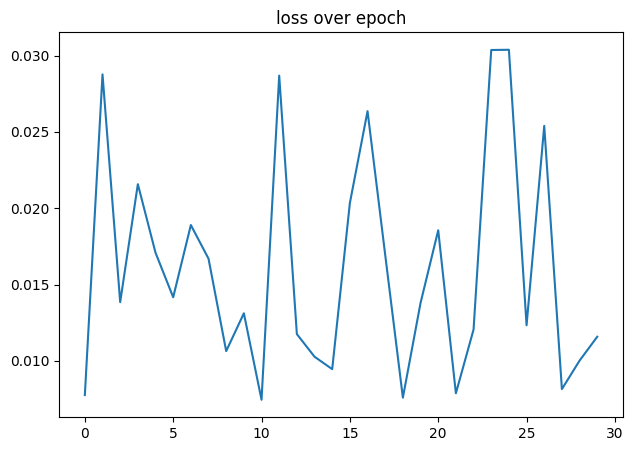

In [11]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.plot(losses)
plt.title("loss over epoch")
plt.savefig("images/training_loss.png")
plt.show()

### Comparaison (oos)

In [12]:
batch_size_oos = 500

In [13]:
input_seq_cov_miss, Q_emp_miss, Sigma_true_miss, T, Sigma_hat_diag_miss, R_miss          = next(tf_data_generator(batch_size_oos, missing_constant = 2, N_min=60, N_max=60, T_min=30, T_max=30))
input_seq_cov_no_miss, Q_emp_no_miss, Sigma_true_no_miss, T, Sigma_hat_diag_no_miss, R_no_miss = next(tf_data_generator(batch_size_oos, missing_constant = 1, N_min=60, N_max=60, T_min=30, T_max=30))

In [89]:
R_miss.shape

TensorShape([500, 60, 30])

In [88]:
(~np.isnan(R_miss.numpy())).all(axis=1).sum(axis=-1)

array([15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
       15, 15, 15, 15, 15

In [93]:
mask = np.isnan(R_miss)

cumsum_rev = np.cumsum(mask[:, ::-1], axis=1)

# remettre dans l'ordre
cumsum_rev = cumsum_rev[:, ::-1]

# position où il n'y a plus de NaN après
valid_from = (cumsum_rev == 0)

# premier True sur chaque ligne
t0 = valid_from.argmax(axis=1)
# si aucune période valide
t0[~valid_from.any(axis=1)] = -1
print(t0)



[[-1 -1 -1 ...  0  0  0]
 [-1 -1 -1 ...  0  0  0]
 [-1 -1 -1 ...  0  0  0]
 ...
 [-1 -1 -1 ...  0  0  0]
 [-1 -1 -1 ...  0  0  0]
 [-1 -1 -1 ...  0  0  0]]


In [28]:
R_miss.shape

TensorShape([500, 60, 30])

In [ ]:
R_miss[:,:,-15:]

TensorShape([500, 60, 15])

In [29]:
T

30

In [32]:
lam_emp_miss     = input_seq_cov_miss[:,:,0]
lam_pred_miss    = model_generated_data(input_seq_cov_miss) # ,lam_emp_miss
lam_emp_no_miss  = input_seq_cov_no_miss[:,:,0]
lam_pred_no_miss = model_generated_data(input_seq_cov_no_miss) # ,lam_emp_no_miss

In [33]:
lam_emp_miss[0]

<tf.Tensor: shape=(60,), dtype=float32, numpy=
array([-5.5660737e-01, -5.1833349e-01, -4.0593278e-01, -3.2389048e-01,
       -2.7854896e-01, -2.6688430e-01, -2.3205203e-01, -1.9876453e-01,
       -1.7356633e-01, -1.6090693e-01, -1.4324184e-01, -1.2200128e-01,
       -1.1004154e-01, -8.8432007e-02, -8.5513636e-02, -8.1111722e-02,
       -7.6266937e-02, -7.1098022e-02, -6.5515205e-02, -6.2701449e-02,
       -5.5458460e-02, -4.9566694e-02, -4.5875777e-02, -3.9305016e-02,
       -3.8797375e-02, -3.5397790e-02, -3.3398017e-02, -2.8368223e-02,
       -2.6314836e-02, -2.3540787e-02, -2.1240080e-02, -1.9153388e-02,
       -1.6924709e-02,  4.2632720e-03,  7.0918828e-02,  1.3235767e-01,
        2.2551724e-01,  4.6381733e-01,  6.7672926e-01,  7.1282983e-01,
        8.3927476e-01,  9.8390013e-01,  1.0250332e+00,  1.1924917e+00,
        1.2390010e+00,  1.6149071e+00,  1.7943951e+00,  2.0758951e+00,
        2.2569129e+00,  2.6218948e+00,  2.6736920e+00,  3.1359234e+00,
        3.4238172e+00,  3.8586

In [34]:
lam_pred_miss[0]

<tf.Tensor: shape=(60,), dtype=float32, numpy=
array([0.7954127 , 0.92297906, 0.9482491 , 0.9501286 , 0.9716385 ,
       0.9850313 , 1.0044163 , 0.9626836 , 0.9673026 , 0.9806694 ,
       0.99122196, 1.0233717 , 0.9783801 , 1.0046709 , 1.0079963 ,
       1.0381017 , 1.0301915 , 1.0005094 , 1.0179627 , 1.0365334 ,
       1.0122808 , 1.033539  , 0.99491966, 1.0393834 , 1.0269066 ,
       1.0384508 , 1.0045497 , 1.0119966 , 1.0237106 , 1.0465301 ,
       1.0631164 , 1.0706729 , 1.0390038 , 0.97490364, 0.99792325,
       0.9783892 , 1.0110762 , 1.013916  , 1.0035971 , 1.0226136 ,
       0.9972001 , 1.0143809 , 1.0098249 , 1.0108347 , 0.9837334 ,
       1.0010192 , 0.9883388 , 0.9988362 , 0.9924721 , 0.97664994,
       0.97595084, 0.96080846, 0.9714235 , 0.9820102 , 0.9564578 ,
       0.9629581 , 0.9806065 , 1.003113  , 1.0457169 , 1.1627359 ],
      dtype=float32)>

Comparaison matrix $Corr$

In [35]:
# Corr from predicted eigenvalues
Corr_pred_miss = tf.matmul(
    tf.matmul(Q_emp_miss, tf.linalg.diag(lam_pred_miss)),
    Q_emp_miss,
    transpose_b=True
)

Corr_pred_no_miss = tf.matmul(
    tf.matmul(Q_emp_no_miss, tf.linalg.diag(lam_pred_no_miss)),
    Q_emp_no_miss,
    transpose_b=True
)

# Corr from empirical eigenvalues
Corr_emp_miss = tf.matmul(
    tf.matmul(Q_emp_miss, tf.linalg.diag(lam_emp_miss)),
    Q_emp_miss,
    transpose_b=True
)

Corr_emp_no_miss = tf.matmul(
    tf.matmul(Q_emp_no_miss, tf.linalg.diag(lam_emp_no_miss)),
    Q_emp_no_miss,
    transpose_b=True
)

In [36]:
# MISS
diag_oos_miss = tf.linalg.diag_part(Sigma_true_miss)
std_oos_miss = tf.sqrt(tf.maximum(diag_oos_miss, 1e-12))
Corr_true_miss = Sigma_true_miss / (
    std_oos_miss[:, None, :] * std_oos_miss[:, :, None] + 1e-12
)

# NO MISS
diag_oos_no_miss = tf.linalg.diag_part(Sigma_true_no_miss)
std_oos_no_miss = tf.sqrt(tf.maximum(diag_oos_no_miss, 1e-12))
Corr_true_no_miss = Sigma_true_no_miss / (
    std_oos_no_miss[:, None, :] * std_oos_no_miss[:, :, None] + 1e-12
)

In [37]:
fro_Corr_pred_miss    = mse(Corr_pred_miss, Corr_true_miss)
fro_Corr_pred_no_miss = mse(Corr_pred_no_miss, Corr_true_no_miss)
fro_Corr_emp_miss     = mse(Corr_emp_miss, Corr_true_miss)
fro_Corr_emp_no_miss  = mse(Corr_emp_no_miss, Corr_true_no_miss)

In [38]:
print(f"MSE Corr after miss + NN:         {fro_Corr_pred_miss.numpy():.6f}")
print(f"MSE Corr after no miss + NN :     {fro_Corr_pred_no_miss.numpy():.6f}")
print(f"MSE Corr after miss + no NN :     {fro_Corr_emp_miss.numpy():.6f}")
print(f"MSE Corr after no miss  + no NN : {fro_Corr_emp_no_miss.numpy():.6f}")

MSE Corr after miss + NN:         0.000493
MSE Corr after no miss + NN :     0.000446
MSE Corr after miss + no NN :     0.054137
MSE Corr after no miss  + no NN : 0.033930


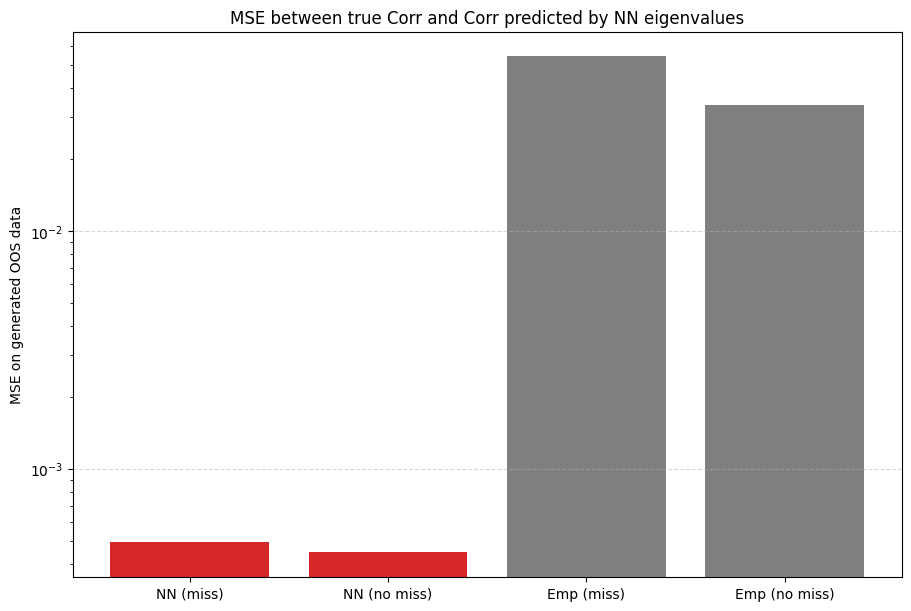

In [39]:
labels = ['NN (miss)', 'NN (no miss)', 'Emp (miss)', 'Emp (no miss)']
values = [
    fro_Corr_pred_miss.numpy(),
    fro_Corr_pred_no_miss.numpy(),
    fro_Corr_emp_miss.numpy(),
    fro_Corr_emp_no_miss.numpy(),
]

colors = ['tab:red','tab:red','tab:gray','tab:gray']

plt.figure(figsize=(9,6), constrained_layout=True)
plt.bar(labels, values, color=colors)
plt.yscale('log')
plt.ylabel('MSE on generated OOS data')
plt.title("MSE between true Corr and Corr predicted by NN eigenvalues")
plt.grid(axis='y', ls='--', alpha=.5)
plt.show()

In [ ]:
D_miss = tf.cast(tf.sqrt(tf.linalg.diag(Sigma_hat_diag_miss)), tf.float32)
D_no_miss = tf.cast(tf.sqrt(tf.linalg.diag(Sigma_hat_diag_no_miss)), tf.float32)

Corr_pred_miss = tf.cast(Corr_pred_miss, tf.float32)
Corr_pred_no_miss = tf.cast(Corr_pred_no_miss, tf.float32)
Corr_emp_miss = tf.cast(Corr_emp_miss, tf.float32)
Corr_emp_no_miss = tf.cast(Corr_emp_no_miss, tf.float32)

Sigma_pred_miss = tf.matmul(tf.matmul(D_miss, Corr_pred_miss), D_miss)
Sigma_pred_no_miss = tf.matmul(tf.matmul(D_no_miss, Corr_pred_no_miss), D_no_miss)
Sigma_emp_miss = tf.matmul(tf.matmul(D_miss, Corr_emp_miss), D_miss)
Sigma_emp_no_miss = tf.matmul(tf.matmul(D_no_miss, Corr_emp_no_miss), D_no_miss)

In [84]:
Sigma_QIS = tf_QIS_batched(R_miss[:,:,-2:])

In [85]:
R_miss[0,:,-1:].shape


TensorShape([60, 1])

In [86]:
fro_Sigma_pred_miss    = mse(Sigma_pred_miss, Sigma_true_miss)
fro_Sigma_pred_no_miss = mse(Sigma_pred_no_miss, Sigma_true_no_miss)
fro_Sigma_emp_miss     = mse(Sigma_emp_miss, Sigma_true_miss)
fro_Sigma_emp_no_miss  = mse(Sigma_emp_no_miss, Sigma_true_no_miss)
fro_Sigma_QIS          = mse(Sigma_QIS, Sigma_true_no_miss)

In [ ]:
print(f"MSE Sigma after miss + NN:         {fro_Sigma_pred_miss.numpy():.6f}")
print(f"MSE Sigma after no miss + NN :     {fro_Sigma_pred_no_miss.numpy():.6f}")
print(f"MSE Sigma after miss + no NN :     {fro_Sigma_emp_miss.numpy():.6f}")
print(f"MSE Sigma after no miss  + no NN : {fro_Sigma_emp_no_miss.numpy():.6f}")
print(f"MSE Sigma QIS :                    {fro_Sigma_QIS.numpy():.6f}")

MSE Sigma after miss + NN:         0.002140
MSE Sigma after no miss + NN :     0.001603
MSE Sigma after miss + no NN :     0.056132
MSE Sigma after no miss  + no NN : 0.035038
MSE Sigma QIS :                    0.001340


/var/folders/l1/kv6fjcx118x75w1kjzdxphsm0000gp/T/ipykernel_76744/132896052.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


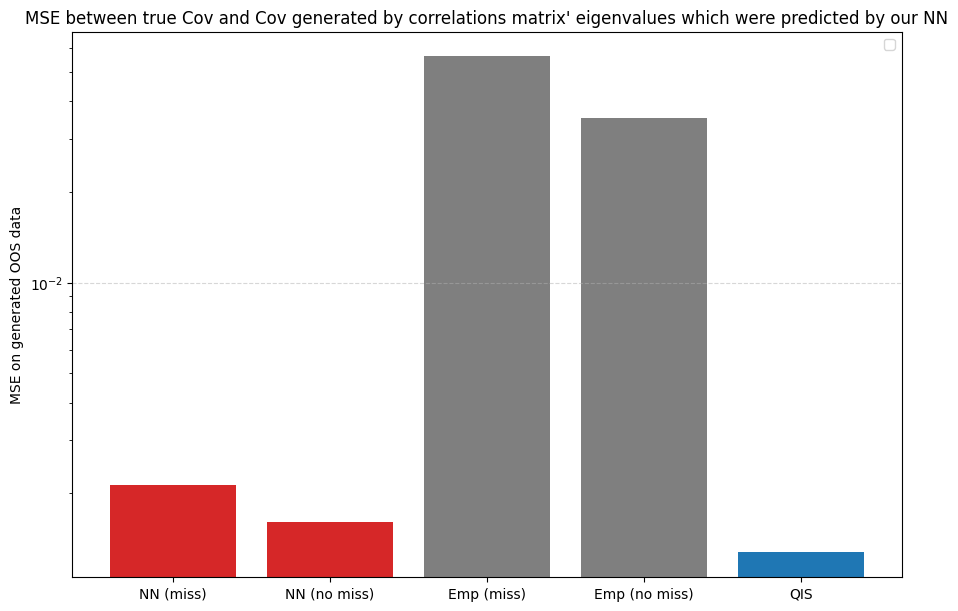

In [62]:
labels = ['NN (miss)', 'NN (no miss)', 'Emp (miss)', 'Emp (no miss)', 'QIS']# 'projected Em (miss)' 'projected Em (no miss)']
values = [fro_Sigma_pred_miss.numpy(), fro_Sigma_pred_no_miss.numpy(), fro_Sigma_emp_miss.numpy(), fro_Sigma_emp_no_miss.numpy(), fro_Sigma_QIS.numpy()]# fro_Sigma_near_miss.item(), fro_Sigma_near_no_miss.item()]
colors = ['tab:red','tab:red','tab:gray','tab:gray', 'tab:blue']#,, 'tab:gray''tab:gray']

plt.figure(figsize=(9,6), constrained_layout=True)
plt.bar(labels, values, color=colors)
plt.yscale('log')
plt.ylabel('MSE on generated OOS data')
plt.title("MSE between true Cov and Cov generated by correlations matrix' eigenvalues which were predicted by our NN")
plt.grid(axis='y', ls='--', alpha=.5)
plt.legend()
plt.show()
